_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Sascha Mühlinghaus, Max Bardelang

LLM Disclaimer: Copilot for generating repetitive code in plotting , boilerplate code and nasty indexing tasks

# Coding Lab 8: Neural Morphologies

## Introduction

The anatomical shape of a neuron — its morphology — has fascinated scientists ever since the pioneering work of Cajal (Ramon y Cajal, 1911). A neuron's dendritic and axonal processes naturally decide what other neurons it can connect to, hence, its shape plays an important role for its function in the circuit. In particular, different functional types of neurons have fundamentally different morphologies.

This notebook will introduce you to the analysis of neural morphologies using the dendrites of over $500$ retinal ganglion cells. The aim is to teach you two different ways of representing morphologies and give you an impression of their repsective strengths and weaknesses.

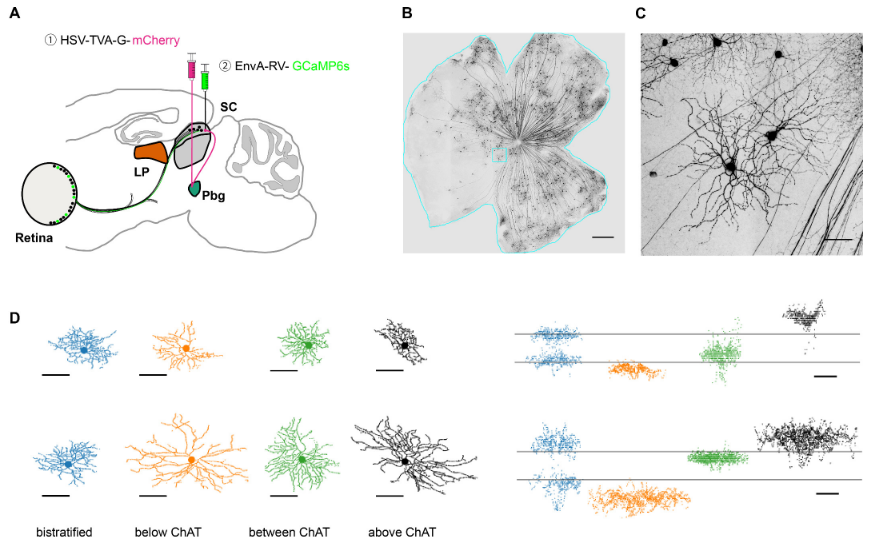

### 1. Data

The data set contains morphological reconstructions of $599$ retinal ganglion cell dendrites with cell type label and projection target to either the parabigeminal (Pbg) or the pulvinar nucleus (LP)([Reinhard et al. (2019)](https://elifesciences.org/articles/50697)). 
Here we only keep cells that map to clusters with more than six cells per cluster which leads to $550$ remaining reconstructions. 

Download the data file `nds_cl_8.zip` from ILIAS and unzip it in a subfolder `../data/`


### 2. Toolbox

We will use MorphoPy (Laturnus, et al., 2020; https://github.com/berenslab/MorphoPy) for this exercise. We recommend to use the Github version, as it is more up-to-date:

```
git clone https://github.com/berenslab/MorphoPy
pip install -e MorphoPy
```

Most of the computations and even some plottings will be handled by MorphoPy. You can learn more about MorphoPy's APIs in this [tutorial](https://nbviewer.jupyter.org/github/berenslab/MorphoPy/blob/master/notebooks/MORPHOPY%20Tutorial.ipynb). 

In [74]:
import pandas as pd
import numpy as np
import os

from morphopy.computation import file_manager
from morphopy.neurontree.plotting import show_threeview
from morphopy.neurontree import NeuronTree as nt

import warnings

warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearnv

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-22 15:56:38CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

sklearnv: not installed

openTSNE  : 1.0.2
numpy     : 2.2.5
morphopy  : 0.7.2
sklearn   : 1.6.1
seaborn   : 0.13.2
matplotlib: 3.10.1
pandas    : 2.2.3

Watermark: 2.5.0



In [75]:
# plt.style.use("/matplotlib_style.txt")

# Inspect the raw data

#### File format

Morphological reconstructions are typically stored in the SWC file format, a simple text file that holds node information in each row and connects nodes through the `parent` node id. A parent id of -1 indicates no parent, so the starting point of the tree graph, also called the root. 
The `type` label indicates the node type (1: somatic , 2: axonal, 3: dendritic (basal), 4: dendritic (apical), 5+: custom).
The code snippet below loads in one swc file and prints its head. 

You can find a more detailed specification of SWC and SWC+ [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html) and [here](https://neuroinformatics.nl/swcPlus/).



In [76]:
def load_swc(filepath: str) -> pd.DataFrame:
    """Loads in the swc located at filepath as a pandas dataframe.

    Args:
        filepath (str): The path to the swc file.

    Returns:
        pd.DataFrame: A pandas dataframe containing the swc file.
    """
    swc = pd.read_csv(
        filepath,
        delim_whitespace=True,
        comment="#",
        names=["n", "type", "x", "y", "z", "radius", "parent"],
        index_col=False,
    )
    return swc


# define color for each cluster
colors = sns.color_palette("rainbow_r", n_colors=14)

In [77]:
# import swc file
PATH = "../data/nds_cl_8/"
data_path = PATH + "reconstructions/soma-centered/"
filename = "0006_00535_4L_C02_01.swc"
filepath = data_path + filename

swc = load_swc(filepath)
swc.head()

,n,type,x,y,z,radius,parent
0,1,1,0.00,0.00,0.47,1.0,-1
1,2,3,-0.03,0.00,0.47,1.0,1
2,3,3,0.17,-0.08,0.51,1.0,1
3,4,3,0.24,-0.31,0.38,1.0,3
4,5,3,0.02,0.14,0.42,1.0,1


The labels `x`, `y`, and `z` hold a node's 3D coordinate in tracing space (here in microns). For reasons of simplicity we will work with reconstructions that are soma centered in XY.

The assigned cell type labels are stored in the file `rgc_labels.csv` and indexed by their `Cell_nr`. In this file you find three different cluster assignments: `clusterA` is the assignment of the authors (clus1 -- clus14), `clusterB` is the respective cluster identifier of the [Eyewire museum](http://museum.eyewire.org) (also see [Bae et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418305725)), and `clusterC` are molecular or functional label names when available. 
We have formatted the cluster assignments of the authors (`clusterA`) into integer values and stored them in the column `cluster`, which we will use in the following.

In [78]:
labels = pd.read_csv(PATH + "rgc_labels.csv", index_col=0)

cluster_label, cluster_counts = np.unique(labels["cluster"], return_counts=True)
labels.head()

,Cell_nr,projection_site,clusterA,clusterB,clusterC,cluster
1,2,LP,clus6,4ow,tOFFα,6
2,3,LP,clus2,2an,F-mini-OFF,2
3,4,LP,clus1,1wt,sOFFα,1
4,6,LP,clus7,5to,NaN,7
5,7,LP,clus10,6sn,NaN,10


# Task 1: Plotting individual morphologies

Load data using `file_manager` and plot individual morphologie using `show_threeview` of from `MorphoPy`. It plots all three planar views on the reconstruction. 

Here, XY shows the planar view on top of the retina, and Z denotes the location within the inner plexiform layer (IPL).

Noted, by default, the `file_manager` loads data with `pca_rot=True` and `soma_center=True`. For the all the exercise in this Coding Lab, it's better to set both of them as `False`. 

*Grading: 2pts*

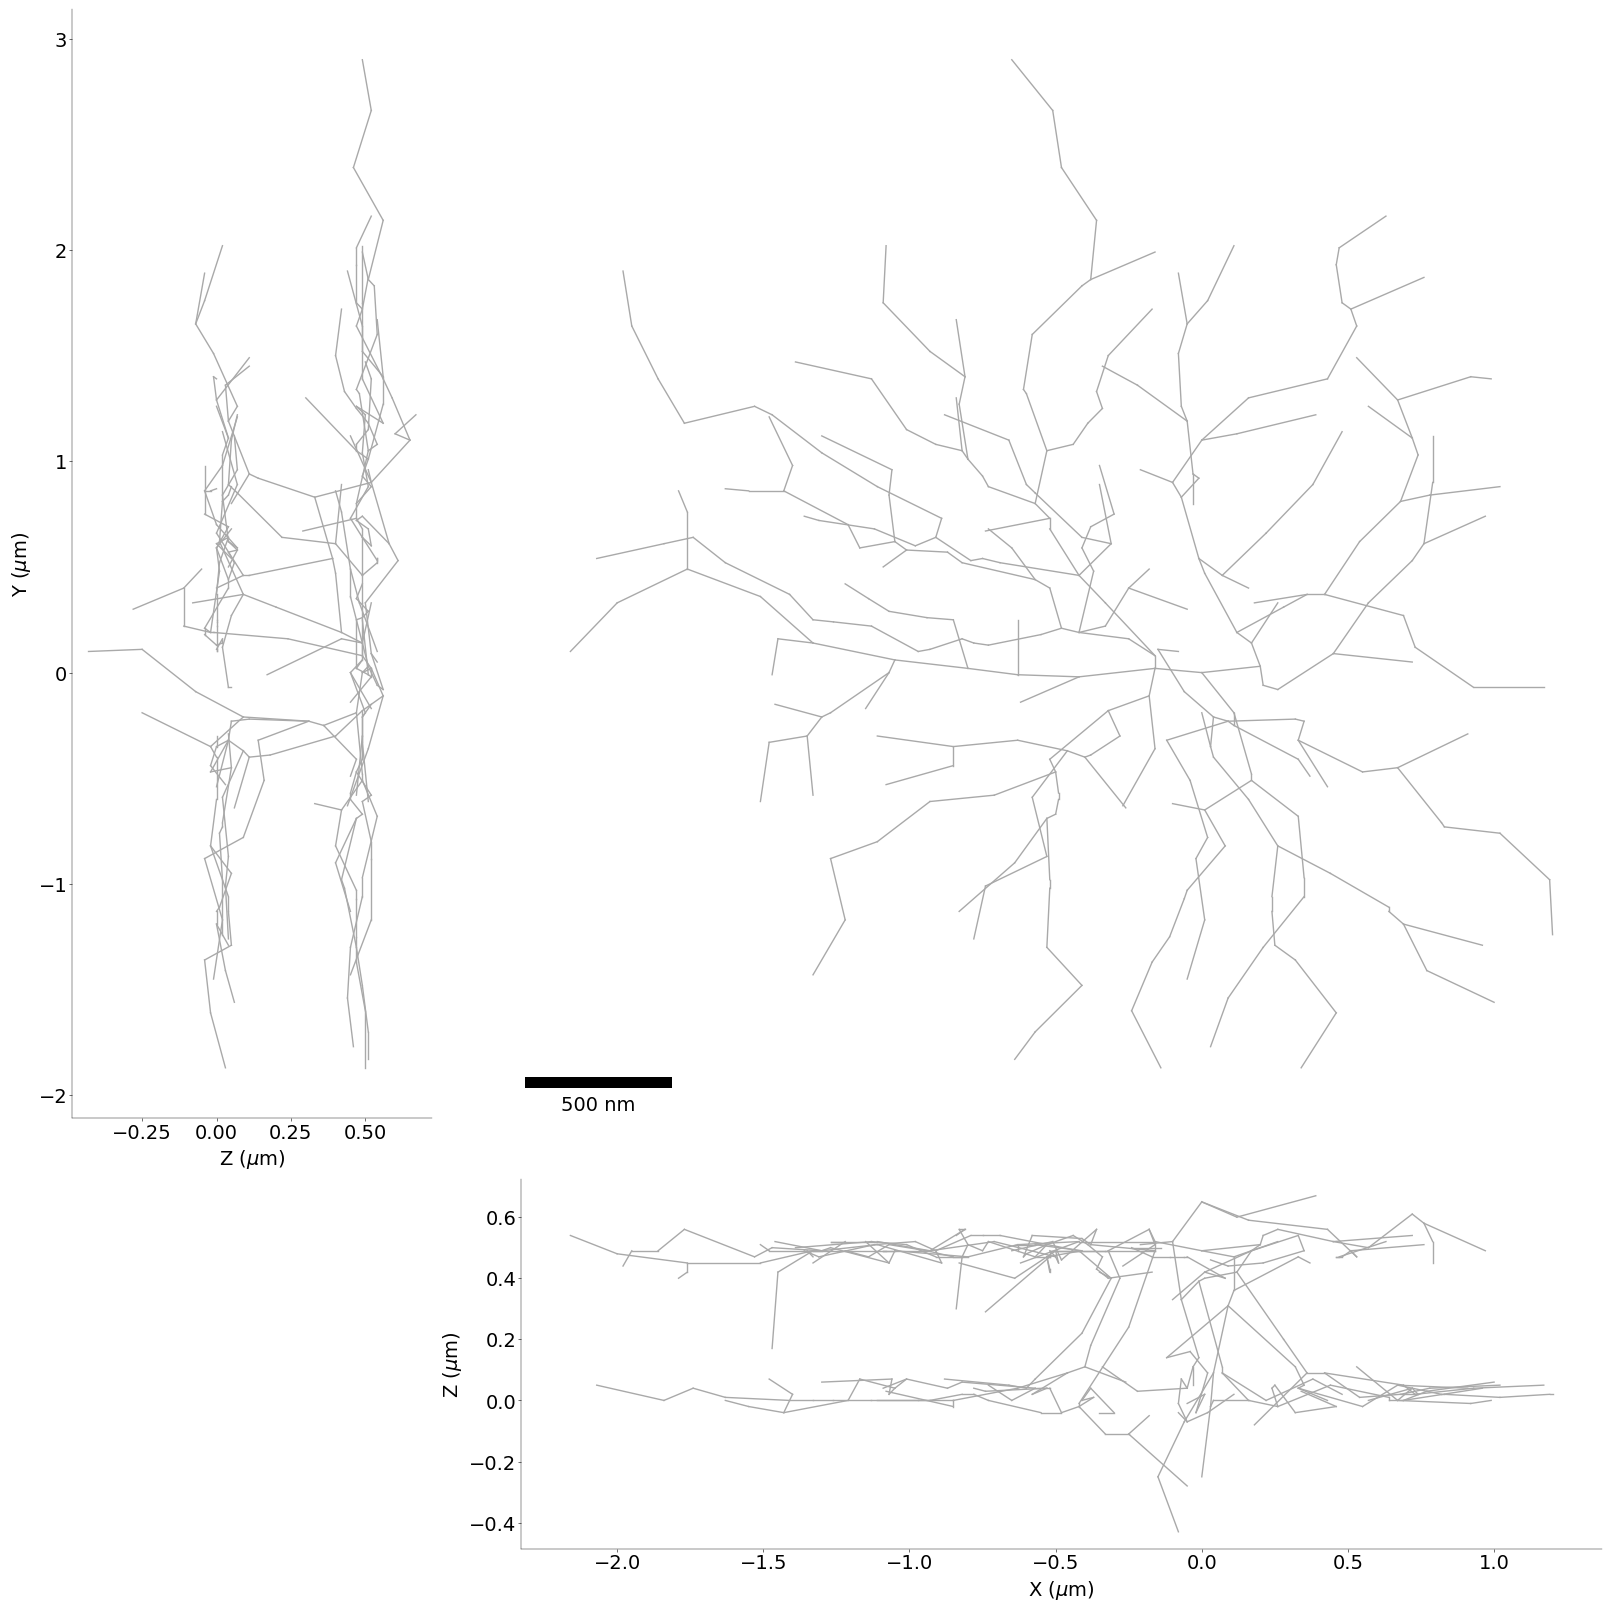

In [79]:
# ----------------------------------------------------------------
# load the example cell "0060_00556_3R_C02_01" with `file_manager`
# from morphology (0.5 pts)
# ----------------------------------------------------------------
filename = "0060_00556_3R_C02_01.swc"
filepath = data_path + filename

nt = file_manager.load_swc_file(filepath, pca_rot=False, soma_center=False)

# -------------------------------------
# plot all three planar views (0.5 pts)
# -------------------------------------

show_threeview(nt)

### Questions (0.5 pts)

1) Describe the dendritic structure of this neuron. How is it special? Can you even give a technical term for its appearance?

**Answer:** This neuron is a bistratified retinal ganglion cell. It extends radially even in the XY plane and forms two distinct layers in the XY plane, 500nm apart in Z-direction.

SWC files are a compact way for storing neural morphologies but their graph structure makes them difficult to handle for current machine learning methods. We, therefore, need to convert our reconstructions into a reasonable vector-like representations. 

Here we will present two commonly chosen representations: Morphometric statistics and density maps


In [80]:
# load all reconstructions. Note: files are sorted by cell number
def load_files(path: str) -> list[nt]:
    """Returns list of NeuronTrees for all .swc files in `path`.
    The reconstructions should be sorted ascendingly by their filename.

    Args:
        path (str): The path to the folder containing the reconstructions.

    Returns:
        list[nt]: An object array of NeuronTrees containing all reconstructions at `path`.
    """
    neurons = []
    # ----------------------------------------------------------
    # use `file_manager` to import all reconstructions (0.5 pts)
    # Note the list should be sorted by filename.
    files = sorted(os.listdir(path))
    for f in files:
        neuron = file_manager.load_swc_file(
            os.path.join(path, f), pca_rot=False, soma_center=False
        )
        neurons.append(neuron)
    return neurons


neurons = load_files(data_path)
print("Number of reconstructions: ", len(neurons))

Number of reconstructions:  550


# Task 2: Morphometric statistics

Morphometric statistics denote a set of hand-crafted single valued features such as `soma radius`, `number of tips` or `average branch angle`. For a more detailed explanation of morphometrics please refer to the [MorphoPy documentation](https://github.com/berenslab/MorphoPy#morphometric-statistics).

*Grading: 4pts*

First, let's compute the feature-based representation for each cell using the function `compute_morphometric_statistics` of the MorphoPy package which computes a predefined set of $28$ statistics.


In [81]:
from morphopy.computation.feature_presentation import compute_morphometric_statistics


# --------------------------------------------------------------------------
# 1. extraction the morphometric statistics for the entire data set (0.5 pts)
# --------------------------------------------------------------------------

ms_list = [compute_morphometric_statistics(n) for n in neurons]
# -----------------------------------------------------------------------------------
# 2. concatenate data into one pd.DataFrame and set the `Cell_nr`` as index (0.5 pts)
# -----------------------------------------------------------------------------------

morphometric_statistics = pd.concat(ms_list, ignore_index=False)
morphometric_statistics["Cell_nr"] = labels["Cell_nr"].values
morphometric_statistics.set_index("Cell_nr", inplace=True)
morphometric_statistics

,branch_points,width,depth,height,tips,stems,total_length,avg_thickness,max_thickness,total_surface,...,median_intermediate_segment_pl,median_terminal_segment_pl,log_max_tortuosity,log_min_tortuosity,log_median_tortuosity,max_branch_angle,min_branch_angle,mean_branch_angle,max_degree,tree_asymmetry
Cell_nr,,,,,,,,,,,,,,,,,,,,,
2,66.0,4.12,5.96,0.54,69.0,3.0,65.793587,1.0,1.0,413.393297,...,0.334798,0.456196,0.253612,0.0,0.005766,124.974479,7.286952,50.402105,3.0,0.726199
3,18.0,3.07,2.66,0.68,23.0,1.0,18.657365,1.0,1.0,117.227681,...,0.345014,0.349991,0.285133,0.0,0.000564,110.367090,18.036960,57.088068,3.0,0.738502
4,54.0,5.05,3.53,0.72,61.0,6.0,41.349847,1.0,1.0,259.808753,...,0.202111,0.281069,0.312270,0.0,0.000000,131.508679,25.596621,59.646776,3.0,0.706943
6,36.0,3.45,4.38,0.49,39.0,4.0,32.249580,1.0,1.0,202.630089,...,0.217084,0.412995,0.251400,0.0,0.017747,130.034126,16.436535,54.683803,2.0,0.601296
7,31.0,4.13,3.86,0.58,40.0,7.0,34.647295,1.0,1.0,217.695372,...,0.248395,0.530086,0.217363,0.0,0.024678,104.036243,2.970445,55.498150,3.0,0.579942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,32.0,4.48,5.04,0.52,35.0,1.0,38.767926,1.0,1.0,243.586064,...,0.373744,0.550518,0.302750,0.0,0.015706,119.600410,17.155231,54.207144,3.0,0.711869
760,5.0,2.20,2.28,0.19,7.0,3.0,7.165210,1.0,1.0,45.020342,...,0.160935,0.821178,0.138250,0.0,0.006622,110.027596,44.677182,77.979427,2.0,0.312500
761,11.0,2.71,3.06,0.02,12.0,1.0,15.170208,1.0,1.0,95.317229,...,0.313291,0.979940,0.127268,0.0,0.010192,109.612094,8.011530,55.958036,2.0,0.573333


Now let's visualize the data.

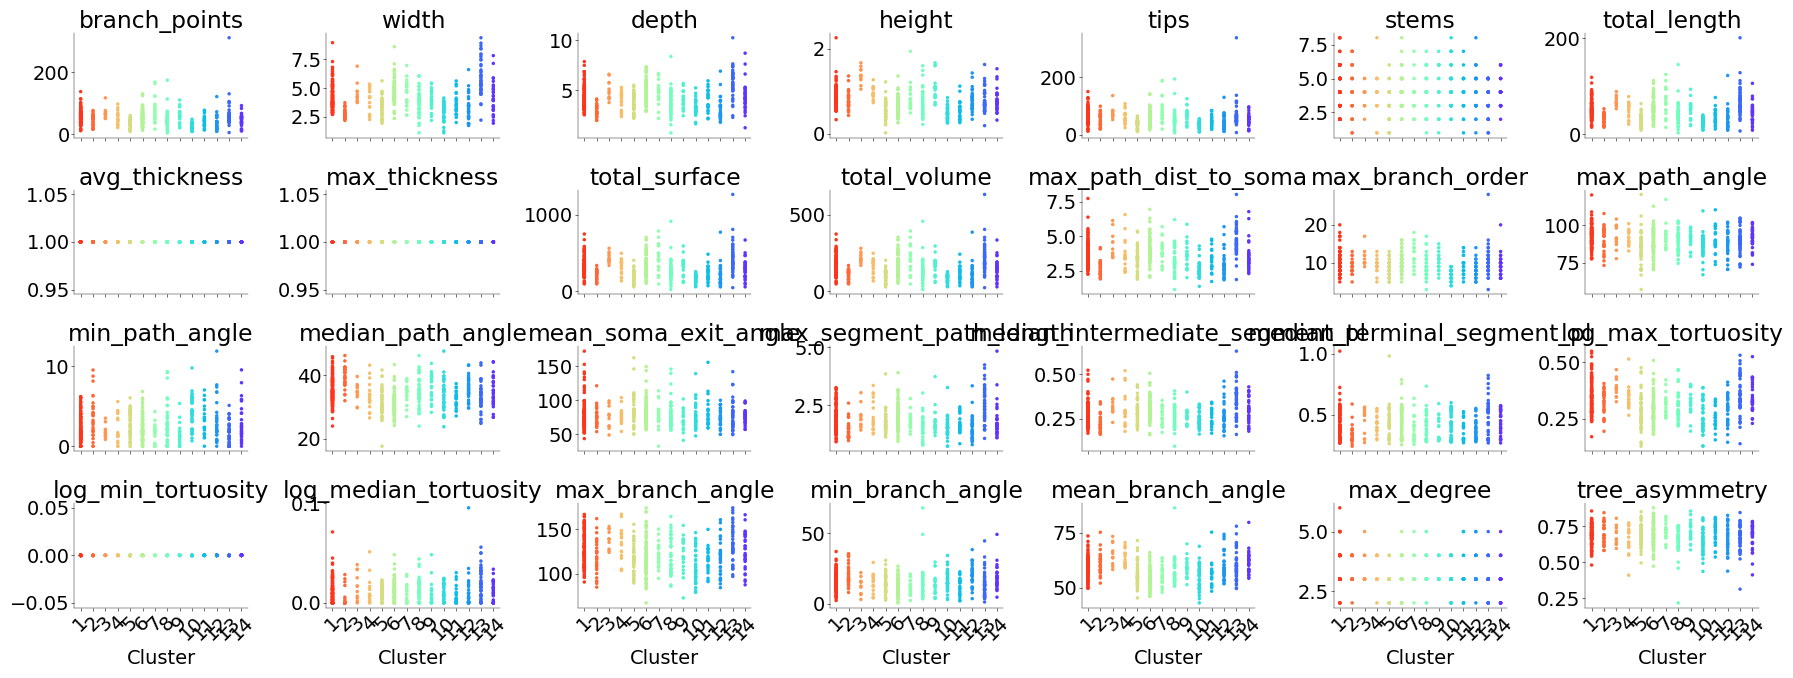

In [82]:
features = morphometric_statistics.columns.values

fig, axes = plt.subplots(4, 7, figsize=(18, 7), sharex=True)
axes = axes.flatten()

# -----------------------------------------------------------
# Create a scatter/strip plot for each morphometric statistic
# showing how it varies across clusters. (2 pts)
# -----------------------------------------------------------


for i, feature in enumerate(features):
    ax = axes[i]
    sns.stripplot(
        data=morphometric_statistics,
        x=labels["cluster"].values,
        y=feature,
        ax=ax,
        jitter=False,
        palette="rainbow_r",
    )
    ax.set_title(feature)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()

### Questions (1 pt)

1) Which statistics separate clusters well? Which can be removed? (tips: there are 5 uninformative features)

**Answer:**
avg_thickness, max_thickness, log_min_toruosity can be removed. Total surface and total volume seem to be highly correlated, so we can remove one of them. The same is true for the number of tips and the number of branches.

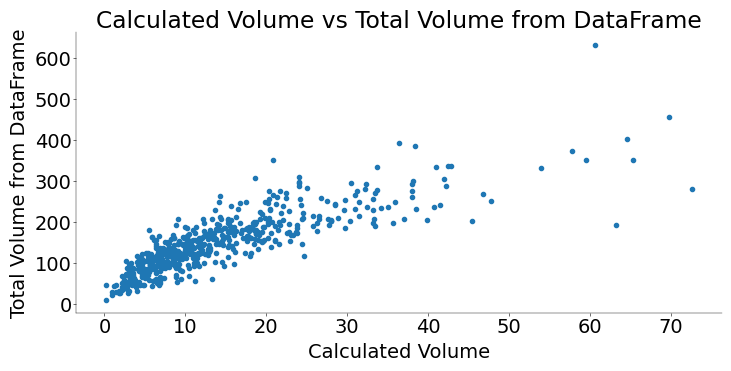

In [83]:
# in the excersise below its stated that volume is uninformative. however, volume results not simply as a product of width, depth and height.

calculated_vol = (
    morphometric_statistics.width
    * morphometric_statistics.depth
    * morphometric_statistics.height
)
plt.scatter(calculated_vol, morphometric_statistics.total_volume)
plt.xlabel("Calculated Volume")
plt.ylabel("Total Volume from DataFrame")
plt.title("Calculated Volume vs Total Volume from DataFrame")
plt.show()

2) More generally, what do morphometric statistics capture well? What are their advantages, what might be their downsides? Briefly explain.

**Answer:**
Morphometric statistics capture the shape, size, and structural features of biological forms. Their advantages include providing quantitative measures that can help identifying groups from complex datasets. Also the structure is indicative of the connectivity to other cells. However, they do not capture activity or dynamics of the cells.Additionally, they may not capture the full complexity of the morphology, leading to potential loss of information.

# Task 3: Density maps

Density maps project a neuron's 3D point cloud ($x$, $y$, $z$) onto a plane or an axis, and bin the projected point cloud into a fixed number of bins. Hereby, the binning controls how much global or local information is kept, which majorly affects the results.

**Exercise:** Compute the density maps of all neurons onto all cardinal planes and axes using the method `compute_density_maps`. You can manipulate the parameters for the density maps via the dictonary `config`. 
Make sure that you normalize the density maps globally and bin each direction into $20$ bins.
You are welcome to explore, how the different projections look like but we will only use the z-projection for further analysis.


Possible parameters to pass are:

- `distance`: (default=1, in microns) determines the resampling distance.
- `bin_size`: (default=20, in microns). If set the number of bins will be computed such that one bin 
spans `bin_size` microns. This is overwritten when `n_bins_x/y/z` is set!
- `n_bins_x/y/z`: (default=None) specifies the number of bins for each dimension. If set it will overwrite the 
`bin_size` flag.
- `density`: (default=True) bool to specify if a density or counts are returned.
- `smooth`: (default=True) bool to trigger Gaussian smoothing.
- `sigma`: (default=1) determines std of the Gaussian used for smoothing. The bigger the sigma the more smoothing occurs. If smooth is set to False this parameter is ignored. 
- `r_min_x/y/z`: (in microns) minimum range for binning of x, y, and z. This value will correspond to the 
minimal histogram edge. 
- `r_max_x/y/z`: (in microns) maximum range for binning for x, y, and z. This value will correspond to the 
maximal histogram edge. 

*Grading: 4pts*

In [84]:
# For further analysis we will remove uninformative features and z-score along each statistic
features_to_drop = [
    "avg_thickness",
    "max_thickness",
    "total_surface",
    "total_volume",
    "log_min_tortuosity",
]
morphometric_data = morphometric_statistics.drop(features_to_drop, axis=1)

# z-score morphometrics and remove nans and uninformative features
morphometric_data = (
    morphometric_data - morphometric_data.mean()
) / morphometric_data.std()
morphometric_data[morphometric_data.isna()] = 0
morphometric_data = morphometric_data.values

In [85]:
# ------------------------------------------------------------------------------------
# Find the minimal and maximal x,y,z - coordinates of the reconstructions to normalize
# the density maps globally using r_min_x/y/z and r_max_x/y/z and print them for
# each direction. (1 pt)
# ------------------------------------------------------------------------------------

all_coords = np.vstack(
    [
        np.array(
            [
                n.get_node_attributes("pos")[node]
                for node in n.get_node_attributes("pos").keys()
            ]
        )
        for n in neurons
    ]
)

r_min_x, r_min_y, r_min_z = all_coords.min(axis=0)
r_max_x, r_max_y, r_max_z = all_coords.max(axis=0)

print(f"Global min coords: x={r_min_x}, y={r_min_y}, z={r_min_z}")
print(f"Global max coords: x={r_max_x}, y={r_max_y}, z={r_max_z}")

Global min coords: x=-6.34, y=-5.49, z=-1.5
Global max coords: x=5.14, y=5.36, z=1.86


In [86]:
from morphopy.computation.feature_presentation import compute_density_maps

config_global = dict(
    # ---------------------------------------------------------------------------------
    # complete the config dict and compute the z-density maps for each neuron (1 pts)
    # ---------------------------------------------------------------------------------
    distance=1,
    n_bins_x=20,
    n_bins_y=20,
    n_bins_z=20,
    density=True,
    smooth=False,
    sigma=1,
    r_min_x=r_min_x,
    r_min_y=r_min_y,
    r_min_z=r_min_z,
    r_max_x=r_max_x,
    r_max_y=r_max_y,
    r_max_z=r_max_z,
)

# Compute density maps for all neurons
density_maps = [compute_density_maps(n, config_global) for n in neurons]

# Extract the z-density maps
dm_z = np.array([dm["z_proj"]["data"] for dm in density_maps])
dm_z

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(550, 20))

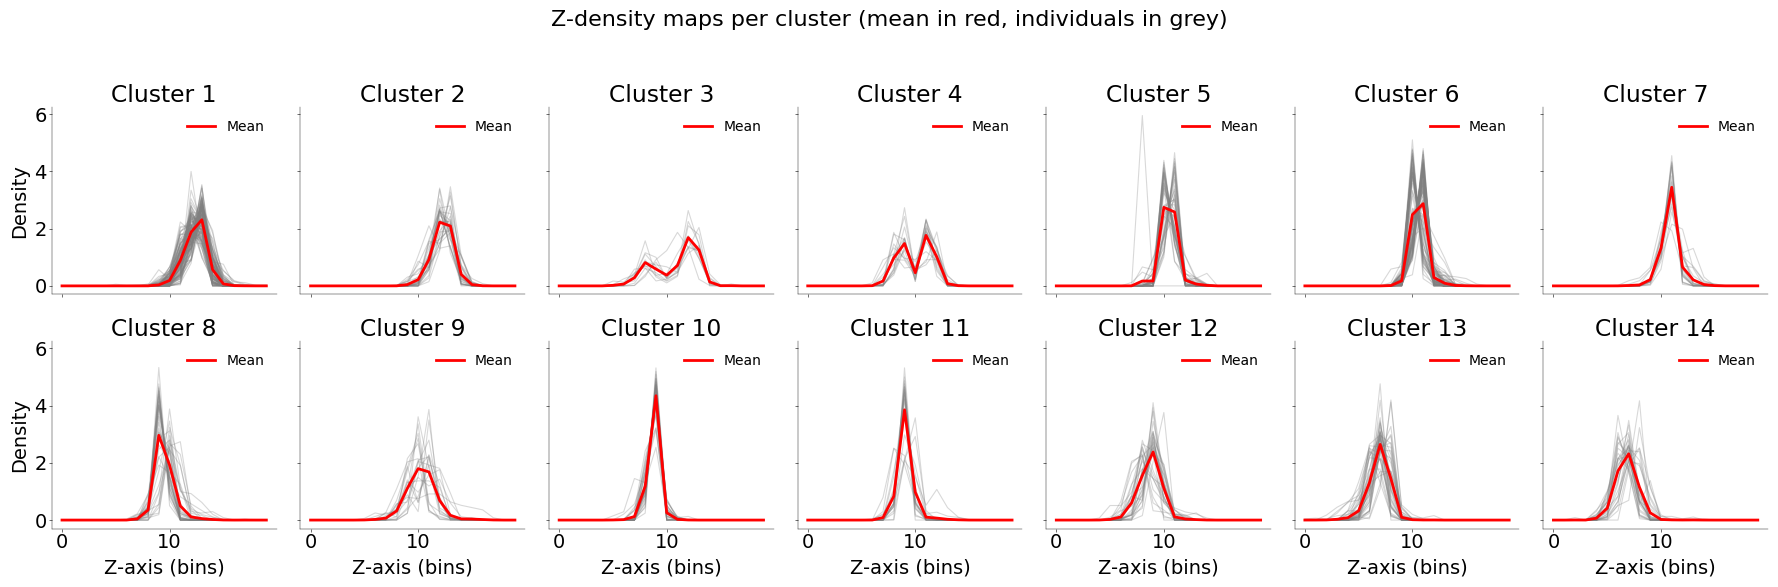

In [87]:
# --------------------------------------------------------------------
# plot the Z-density maps and their means sorted by class label (1 pt)
# Note: make sure the clusters are comparable.
# --------------------------------------------------------------------
# Get cluster labels for each neuron
clusters = labels["cluster"].values

# Calculate the average Z-density map for each cluster
unique_clusters = np.unique(clusters)
mean_dm_z_per_cluster = np.zeros((len(unique_clusters), dm_z.shape[1]))

for i, cl in enumerate(unique_clusters):
    mean_dm_z_per_cluster[i] = np.mean(dm_z[clusters == cl], axis=0)

# Plot the Z-density maps for each cluster in a subplot, with means in red and individual maps in grey
n_clusters = len(unique_clusters)
fig, axes = plt.subplots(
    2, (n_clusters + 1) // 2, figsize=(18, 6), sharex=True, sharey=True
)
axes = axes.flatten()

for i, cl in enumerate(unique_clusters):
    ax = axes[i]
    # Plot all individual Z-density maps for this cluster in grey
    for dm in dm_z[clusters == cl]:
        ax.plot(dm, color="grey", alpha=0.3, linewidth=0.8)
    # Plot the mean Z-density map for this cluster in red
    ax.plot(mean_dm_z_per_cluster[i], color="red", linewidth=2, label="Mean")
    ax.set_title(f"Cluster {cl}")
    # Plot x-label only for the last row
    if i >= 7:
        ax.set_xlabel("Z-axis (bins)")
    # Set y-label only for the first column
    if i == 0 or i == 7:
        ax.set_ylabel("Density")
    ax.legend(loc="upper right")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle(
    "Z-density maps per cluster (mean in red, individuals in grey)", fontsize=16
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Questions (1 pt)

1) What does the Z-density map tell you about the cell types? Can you identify a trend in the density maps?

**Answer:** The Z-density map tells us at which Z-coordinate (height, when looking at the cell "sideways") the most dendrites are. The clusters seem to group into meta-clusters, as for example the densities of clusters 1 & 2 or clusters 13 & 14 are very similar.

2) Which cluster(s) would you expect the cell from Task 1 to come from and why?

**Answer:** The bistratified retinal ganglion cell from Task 1 is likely from cluster 3 or 4, as these show two peaks in density corresponding to the two (bi) layer the cell is stratified to.


# Task 4: 2D embedding using t-SNE


Embed both data, the morphometric statistics and the density maps, in 2D using t-SNE and color each embedded point by its cluster assignment.

*Grading: 3 pts*

In [88]:
from openTSNE import TSNE

# ----------------------------------------------------------------------
# Fit t-SNE with morphometric statistics and density maps (0.5 + 0.5 pt)
# Note that this can take a bit to run. (use perplexity=100
# and a random state of 17)
# ----------------------------------------------------------------------
# Fit t-SNE on morphometric data
tsne_morphometric = TSNE(perplexity=100, random_state=17).fit(morphometric_data)

# Fit t-SNE on density maps
tsne_density = TSNE(perplexity=100, random_state=17).fit(dm_z)

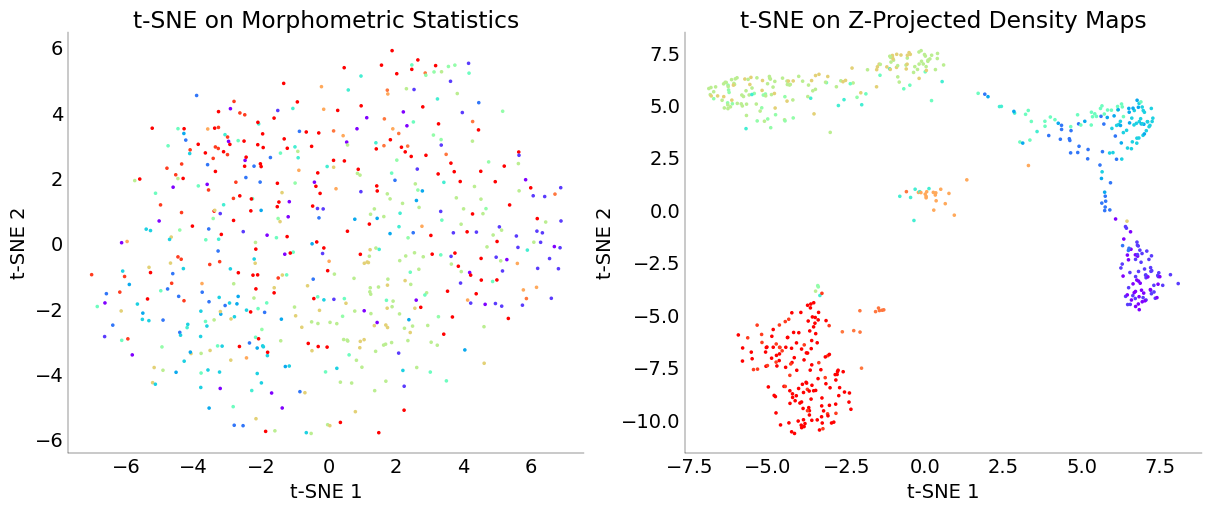

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

# ----------------------------------------------------------------------------
# plot tsne fits for both morpometric statistics and z-projected density maps.
# Color the points appropriately and answer the questions below. (2 pt)
# ----------------------------------------------------------------------------
axes[0].scatter(
    tsne_morphometric[:, 0],
    tsne_morphometric[:, 1],
    c=labels["cluster"].values,
    cmap="rainbow_r",
    s=10,
)
axes[0].set_title("t-SNE on Morphometric Statistics")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
# Hide x and y ticks
axes[0].tick_params(axis="both", which="both", bottom=False, left=False)
# axes[0].set_xticks([])
# axes[0].set_yticks([])

axes[1].scatter(
    tsne_density[:, 0],
    tsne_density[:, 1],
    c=labels["cluster"].values,
    cmap="rainbow_r",
    s=10,
)
axes[1].set_title("t-SNE on Z-Projected Density Maps")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
# Hide x and y ticks
axes[1].tick_params(axis="both", which="both", bottom=False, left=False)
# axes[1].set_xticks([])
# axes[1].set_yticks([])

### Questions:
1) Which representation produces the better clustering? Why could this be the case?

**Answer:** The density map produces much better clustering. Density maps are a much less fine grained measure than morphometric measures as branch order or branch angle. As individual neurons show a large variety even inside each class, such finer grained characteristics have very large variance.

2) What are the advantages of morphometric statistics over density maps 

**Answer:** Morphometric statistics capture a lot more detailed information about the morphology of the neuron, such as branch angles, lengths, and other structural features. This can be useful for understanding the specific connectivity and functional properties of the neuron. They are also more interpretable in terms of biological meaning, as they relate directly to the physical structure of the neuron. However, when it comes to clustering, they can be too fine grained and lead to overfitting, as they capture a lot of noise in the data.

3) What are the advantages of density maps over morphometric statistics?

**Answer:** Density maps provide a more global view of the neuron's morphology, capturing the overall distribution of dendritic processes in space. They are less sensitive to noise and individual variations in morphology, making them more robust for clustering. Density maps also allow for easier visualization of the spatial distribution of dendrites, which can be helpful for understanding the functional properties of the neuron in its circuit context.

# Task 5: Predicting the projection site

The relationship between neuronal morphology and functional specialization is well-established in neurobiology. Hence, we expect distinct functional domains within the thalamus to exhibit corresponding morphological signatures. In this analysis, we aim to predict the thalamic projection site (`labels['projection_site']`) of individual neurons based on their morphological characteristics. Fit a logistic regression on both morphological representations and report its average cross validated (cv=5) prediction accuracy for each. Which representation works better to recover the prediction target? Which features are most relevant for that prediction?

You can use `LogisticRegressionCV` of the scikit-learn library directly. To understand the relevance of individual features plot the fitted linear coefficients. Note, since the classes are imbalanced make sure to report the balanced prediction accuracy.

*Grading: 2 pts*

In [90]:
from sklearn.linear_model import LogisticRegressionCV

# -----------------------------------------------------------------------------
# Fit a logistic regressor to predict the projection site based on both feature
# representations and print the avg. prediction accuracy (1 pt)
# -----------------------------------------------------------------------------
LR_morpho = LogisticRegressionCV(cv=5, random_state=17, max_iter=1000).fit(
    morphometric_data, labels["projection_site"].values
)
LR_density = LogisticRegressionCV(cv=5, random_state=17, max_iter=1000).fit(
    dm_z, labels["projection_site"].values
)
print(
    f"Average prediction accuracy for morphometric statistics: {LR_morpho.score(morphometric_data, labels['projection_site'].values):.2f}"
)
print(
    f"Average prediction accuracy for z-projected density maps: {LR_density.score(dm_z, labels['projection_site'].values):.2f}"
)

Average prediction accuracy for morphometric statistics: 0.76
Average prediction accuracy for z-projected density maps: 0.70


While Z density maps allow for better recovery of cell type labels, they are worse than morphometric statistics on predicting the projection target. 

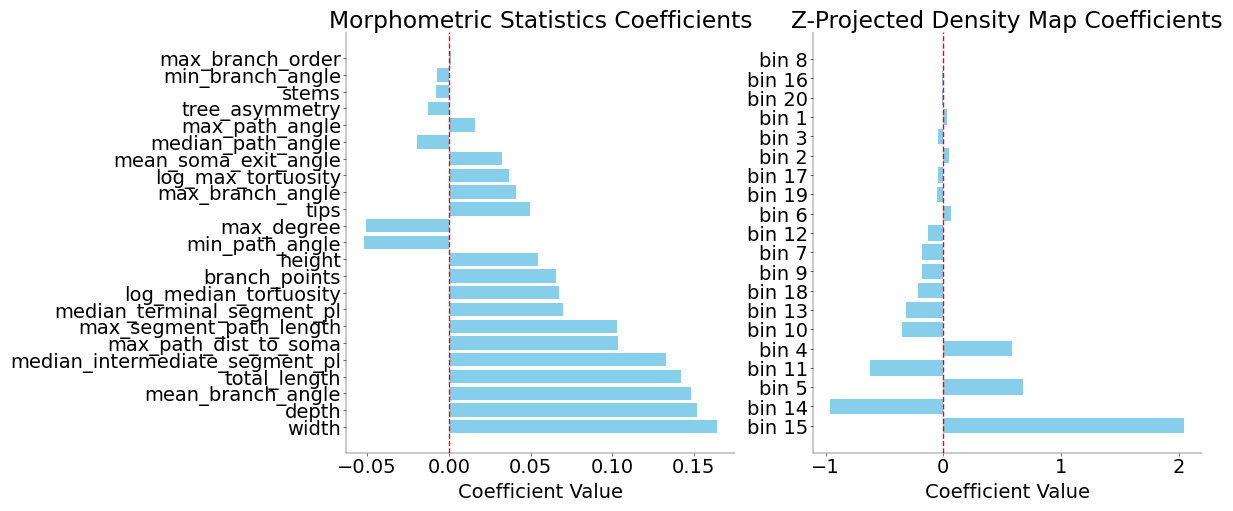

In [91]:
# ---------------------------------------------------------------------------
# Plot the fitted linear coefficients for both of the feature representations
# and answer the question below. (1 pt)
# ---------------------------------------------------------------------------
def plot_coefficients(model, feature_names, ax, title):
    """Plot the coefficients of a logistic regression model, sorted by magnitude."""
    coefs = model.coef_[0]
    # Get sorted indices by absolute value
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    sorted_features = np.array(feature_names)[sorted_idx]
    sorted_coefs = coefs[sorted_idx]
    ax.barh(sorted_features, sorted_coefs, color="skyblue")
    ax.set_title(title)
    ax.set_xlabel("Coefficient Value")
    ax.axvline(0, color="red", linestyle="--")


fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")
plot_coefficients(
    LR_morpho,
    morphometric_statistics.drop(features_to_drop, axis=1).columns.values,
    axes[0],
    "Morphometric Statistics Coefficients",
)
plot_coefficients(
    LR_density,
    ["bin " + str(i + 1) for i in range(dm_z.shape[1])],
    axes[1],
    "Z-Projected Density Map Coefficients",
)

### Question:

1) Which morphometrics are informative on the projection site?

**Answer:** mean_branch_angle, median_intermediate_segment_pl, total_length, depth, width.

# Further references

Other ways to represent and compare morphologies are
* Persistence: [Description](https://link.springer.com/article/10.1007/s12021-017-9341-1) and [application on somatosensory pyramidal cell dendrites](https://academic.oup.com/cercor/article/29/4/1719/5304727) by Kanari et al. 2018

* Tree edit distance: [Heumann et al. 2009](https://link.springer.com/article/10.1007/s12021-009-9051-4)

* Sequential encoding inspired by BLAST: [Encoding](https://link.springer.com/article/10.1186/s12859-015-0604-2) and [similarity analysis on cortical dendrites](https://link.springer.com/article/10.1186/s12859-015-0605-1) by Gilette et al. 2015

* Vector point clouds: [BlastNeuron: Wan et al. 2015](https://link.springer.com/article/10.1007/s12021-015-9272-7)